In [16]:
import itertools

import pandas as pd
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
sns.set_style('darkgrid')

In [18]:
plot_params = {'legend.fontsize': 20,
               'figure.figsize': (20, 10),
               'axes.labelsize':  15,
               'axes.titlesize':  30,
               'xtick.labelsize': 15,
               'ytick.labelsize': 15,
               'figure.dpi': 300}


#plt.rcParams.update(plot_params)

color_dark_blue = [1/255, 62/255, 125/255]
color_light_blue = [6/255, 143/255, 203/255]
purple = [102/255, 51/255, 153/255]

colors = [color_dark_blue, color_light_blue, purple]

color_line = list(itertools.product(['-', ':', '--', ':' '-', ':'], colors))

## Load Data

In [48]:
# get data
df = pd.read_csv('../Data/20241010_data.csv', delimiter=";").dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
# set date column as index
df.set_index('Date', inplace=True)
df.drop('UofM consumer sentiment', axis=1, inplace=True) # drop consumer confidence for now


### Draw macro economic variables

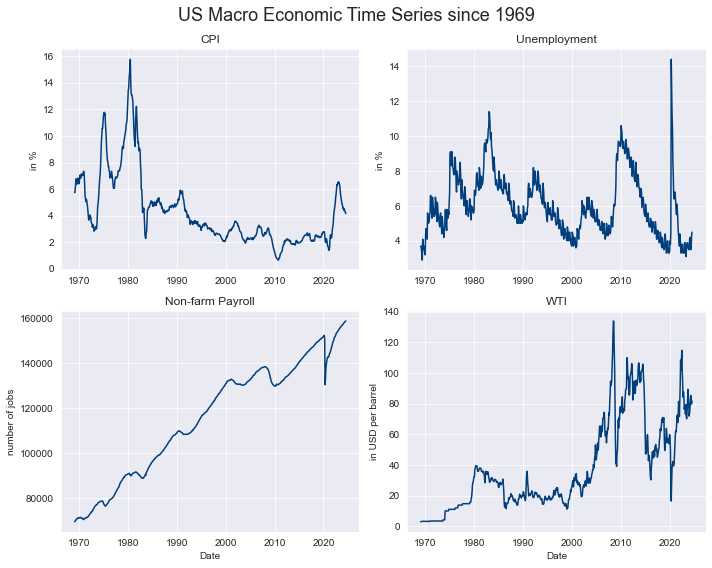

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))


axes[0, 0].plot(df['CPI'], color=color_dark_blue)
axes[0, 0].set_title('CPI')
axes[0, 0].set_ylabel('in %')

axes[0, 1].plot(df['Unemployment'], color=color_dark_blue)
axes[0, 1].set_title('Unemployment')
axes[0, 1].set_ylabel('in %')

axes[1, 0].plot(df['non-farm payroll'], color=color_dark_blue)
axes[1, 0].set_title('Non-farm Payroll')
axes[1, 0].set_ylabel('number of jobs')
axes[1, 0].set_xlabel('Date')


axes[1, 1].plot(df['WTI'], color=color_dark_blue)
axes[1, 1].set_title('WTI')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('in USD per barrel')

plt.suptitle('US Macro Economic Time Series since 1969', fontsize = 18)
plt.tight_layout()
plt.show()


### Draw timeseries of four asset classes

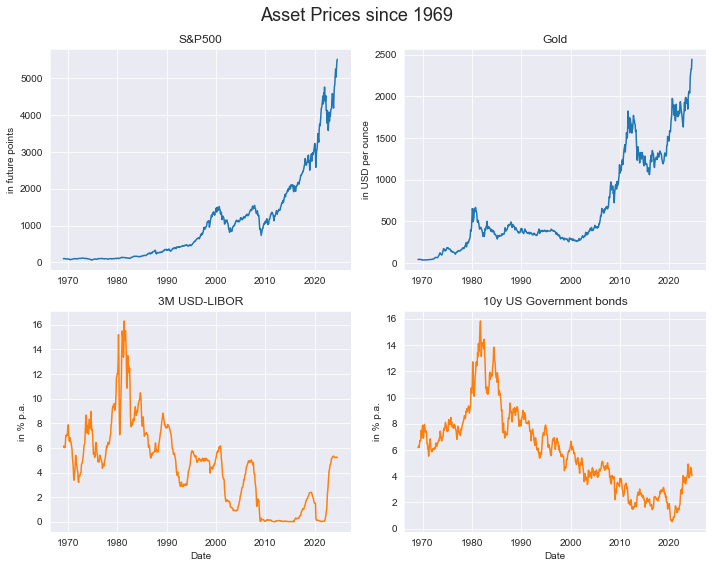

In [80]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))


axes[0, 0].plot(df['SP500'])
axes[0, 0].set_title('S&P500')
axes[0, 0].set_ylabel('in future points')

axes[0, 1].plot(df['Gold'])
axes[0, 1].set_title('Gold')
axes[0, 1].set_ylabel('in USD per ounce')

axes[1, 0].plot(df['3M'], color='#ff7f0e')
axes[1, 0].set_title('3M USD-LIBOR')
axes[1, 0].set_ylabel('in % p.a.')
axes[1, 0].set_xlabel('Date')


axes[1, 1].plot(df['10y'], color='#ff7f0e')
axes[1, 1].set_title('10y US Government bonds')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('in % p.a.')


plt.suptitle('Asset Prices since 1969', fontsize = 18)
plt.tight_layout()
plt.show()

### Calculate price index of 10 year government bond

In [51]:
df.drop('10y treasury Index', axis=1, inplace=True) # drop consumer confidence for now
ten_y_index = [100]
delta = -9.0/100.0
for i in range(len(df['10y'])-1):
    change_in_bp = (df['10y'][i+1] - df['10y'][i])/ df['10y'][i]
    ten_y_index.append(ten_y_index[i] + df['10y'][i]/(12) + change_in_bp * delta)

df['10y treasury Index'] = np.array(ten_y_index)

In [52]:
df.columns

Index(['SP500', 'Gold', '3M', '10y', 'CPI', 'Unemployment', '3M-Index',
       'non-farm payroll', 'WTI', '10y treasury Index'],
      dtype='object')

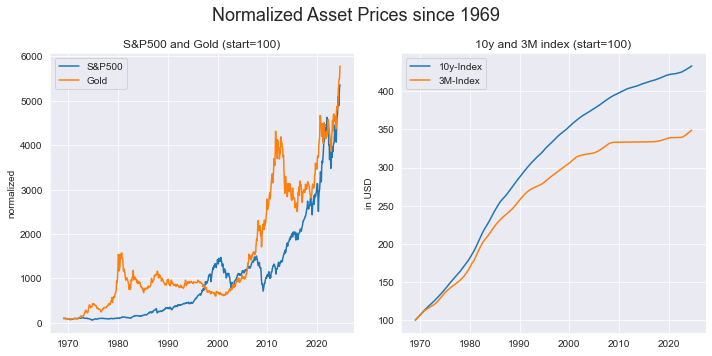

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

df['SP500_adjs'] = df['SP500']/df['SP500'][0] * 100
df['Gold_adjs'] = df['Gold']/df['Gold'][0] *100

axes[0].plot(df[['SP500_adjs','Gold_adjs']], label=['S&P500','Gold'])
axes[0].set_title('S&P500 and Gold (start=100)')
#axes[0].set_yscale('log')
axes[0].set_ylabel('normalized')
axes[0].legend()

axes[1].plot(df[['10y treasury Index','3M-Index']], label=['10y-Index','3M-Index'])
axes[1].set_title('10y and 3M index (start=100)')
axes[1].set_ylabel('in USD')
axes[1].legend()

plt.suptitle('Normalized Asset Prices since 1969', fontsize = 18)
plt.tight_layout()
plt.show()

# Augmented Dickey–Fuller Stationarity Test

In [72]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [73]:
# Test if time series are stationary
# ADF Test on each column
for name, column in df.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "SP500" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 3.6935
 No. Lags Chosen       = 18
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 1.0. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Gold" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.104
 No. Lags Chosen       = 12
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.9953. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "3M" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non

In [74]:
# take difference of timeseries to avoid stationarity
df_test_stationary = df.diff().dropna()

In [75]:
# ADF Test on each column
for name, column in df_test_stationary.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "SP500" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.2824
 No. Lags Chosen       = 20
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Gold" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1863
 No. Lags Chosen       = 11
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "3M" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05


# Vector Autoregressive (VAR)

In [76]:
model = VAR(df_test_stationary)

/Users/johanneswinkler/miniforge3/envs/thesis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)


In [77]:
# find the best lag
model.select_order(maxlags=15).summary()

,AIC,BIC,FPE,HQIC
0,1.052,1.107,2.864,1.074
1,-58.57,-58.07*,3.661e-26,-58.38
2,-58.82*,-57.88,2.857e-26*,-58.45*
3,-54.70,-53.33,1.752e-24,-54.17
4,-56.87,-55.06,1.999e-25,-56.17
5,-57.15,-54.89,1.516e-25,-56.27
6,-54.25,-51.55,2.765e-24,-53.20
7,-54.14,-51.00,3.093e-24,-52.92
8,-53.81,-50.23,4.291e-24,-52.42
9,-54.43,-50.41,2.316e-24,-52.87


In [78]:
model_fitted = model.fit()
lag_order = model_fitted.k_ar

In [79]:
lag_order

1

In [80]:
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 20, Aug, 2024
Time:                     19:11:49
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -56.7229
Nobs:                     665.000    HQIC:                  -57.0214
Log likelihood:           11545.6    FPE:                1.42549e-25
AIC:                     -57.2101    Det(Omega_mle):     5.11044e-26
--------------------------------------------------------------------
Results for equation SP500
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  33.952224         7.058727            4.810           0.000
L1.SP500               -0.107174         0.039272           -2.729           0.006
L1.Gold                -0.038354         0.068595   

## Durbin-Watson

In [81]:
# test if residuals are serialy correlated
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_test_stationary.columns, out):
    print(col, ':', round(val, 2))

SP500 : 2.02
Gold : 2.01
3M : 1.85
10y : 1.98
CPI : 2.14
Unemployment : 2.06
3M-Index : 3.36
10Y_Index : 1.98


## Impulse Response Function

In [23]:
#irf = model_fitted.irf(10)
#_ = irf.plot(orth=False)

# Granger's Causality

In [24]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=8):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [25]:
# test if one time series Granger causes another time series
grangers_causation_matrix(df_test_stationary, variables = df_test_stationary.columns)

,Fed Rate_x,10Y Treasury Yield_x,Gold_x,S&P500_x
Fed Rate_y,1.0000,0.0000,0.8102,0.0475
10Y Treasury Yield_y,0.0000,1.0000,0.3345,0.0170
Gold_y,0.1380,0.1335,1.0000,0.5357
S&P500_y,0.8907,0.6275,0.2471,1.0000


In [82]:
df_test_stationary

,SP500,Gold,3M,10y,CPI,Unemployment,3M-Index,10Y_Index
Date,,,,,,,,
1969-02-28,-4.88,0.30,-0.02,0.0700,0.003759,0.0,0.511667,-0.114000
1969-03-31,3.38,0.60,-0.10,0.0400,0.375202,-0.2,0.510000,0.161833
1969-04-30,2.18,0.10,0.09,-0.1000,0.380463,-0.3,0.501667,1.425167
1969-05-30,-0.23,0.16,-0.07,0.3600,0.275014,-0.3,0.509167,-2.723167
1969-06-30,-5.75,-2.02,0.40,0.1700,-0.404668,1.2,0.503333,-0.983167
...,...,...,...,...,...,...,...,...
2024-03-29,158.08,185.57,0.00,-0.0499,0.106110,-0.3,0.436667,0.803283
2024-04-30,-218.66,56.38,0.00,0.4795,-0.096818,-0.4,0.436667,-3.965475
2024-05-31,241.82,41.08,0.01,-0.1813,-0.110371,0.2,0.436667,2.021683


#### Idee: Ziehe zufällig einen Datenpunkt aus der Zeitreihe
#### addiere white-noise mit korrekter Correlation auf den Datenpunkt
#### verwende diesen als Startpunkt für eine Schätzung immer einen Monat in die Zukunft
#### wiederhole dies 360-mal

In [ ]:
model = VAR(df_test_stationary)
model_fitted = model.fit()
lag_order = model_fitted.k_ar

In [96]:
# random observation
import random

rand_numb = random.randint(1, df_test_stationary.shape[0])
forecast_window = 1

In [97]:
# inputs to generate a random vector
mean_vector = np.zeros(df_test_stationary.shape[1])
covariance_matrix = df_test_stationary.cov()

In [101]:
# random start value
# df_test_stationary.values[rand_numb - lag_order: rand_numb]

array([[-0.18      ,  0.15      , -0.02      , -0.142     , -0.14880788,
        -0.3       ,  0.4516666 ,  1.8135    ]])

In [126]:
numb_obs = 360

df_results = pd.DataFrame(columns=df.columns, index=range(numb_obs))
df_forecast = pd.DataFrame(columns=df.columns, index=range(numb_obs))

random_vector = np.random.multivariate_normal(mean_vector, covariance_matrix)

forecast_input = df_test_stationary.values[rand_numb - lag_order: rand_numb] + random_vector
fc = model_fitted.forecast(y=forecast_input, steps=forecast_window)

df_forecast.iloc[0,:] = fc
df_results.iloc[0,:] = df.values[rand_numb - lag_order: rand_numb] + fc[0]


# all subsequent values
for i in range(1,numb_obs):
    forecast_input = df_forecast.values[i-lag_order: i] + np.random.multivariate_normal(mean_vector, covariance_matrix)
    fc = model_fitted.forecast(y=forecast_input, steps=forecast_window)
    df_forecast.iloc[i,:] = fc
    df_results.iloc[i,:] = df_results.iloc[i-1,:] + fc[0]

In [124]:
df_results

,SP500,Gold,3M,10y,CPI,Unemployment,3M-Index,10Y_Index
0,599.963731,392.977736,5.107996,6.431059,3.378556,6.176987,284.348108,325.551751
1,615.023668,404.02687,4.722996,6.45505,3.189527,6.280734,284.789051,325.890863
2,624.790005,421.208627,4.279441,6.437014,3.180753,6.388732,285.088963,326.476245
3,610.604879,411.991673,4.337707,6.399343,3.128186,6.246773,285.327307,327.368553
4,612.799444,408.145113,4.408674,6.323839,2.959226,6.183466,285.691835,328.645526
...,...,...,...,...,...,...,...,...
355,-9206.058226,-3178.7404,-27.370773,-45.133075,-58.328078,10.25889,717.727259,1326.104226
356,-9212.475,-3178.950164,-27.644179,-45.288359,-58.316916,10.506386,718.883723,1328.799654
357,-9235.942866,-3181.295628,-27.77322,-45.36228,-58.294372,10.576768,720.212545,1330.97105
358,-9236.10692,-3174.09996,-28.482959,-45.581483,-58.324556,11.041953,721.562218,1334.371336


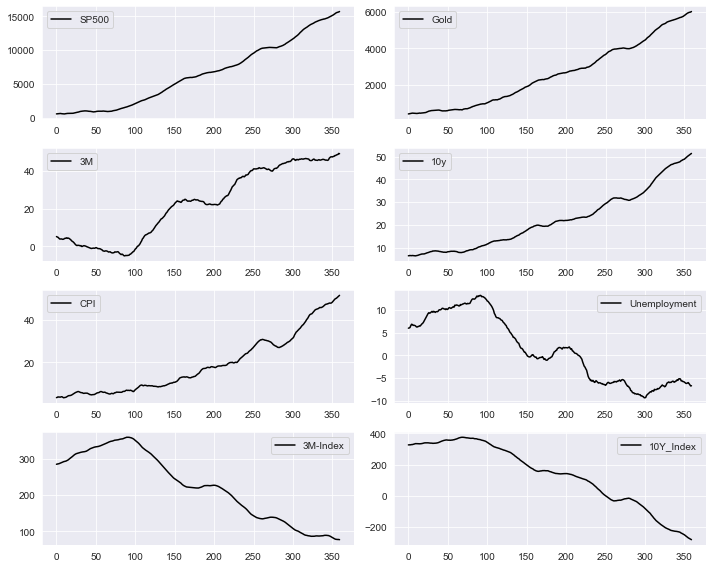

In [127]:
sns.set_style('darkgrid')


# plot the results
#fig, axes = plt.subplots(nrows=len(df_test.columns),figsize=(10,20))
fig, axes = plt.subplots(4,2, figsize=(10,8))
for i, (col,ax) in enumerate(zip(df_results.columns, axes.flatten())):
    df_results[col].plot(legend=True, ax=ax, color='black')
    

plt.tight_layout()

# Forecasting

In [108]:
mean = df_test_stationary.mean()
cov_mat = df_test_stationary.cov()
mean, cov_mat

(Fed Rate             -0.038866
 10Y Treasury Yield   -0.022466
 Gold                  2.611207
 SP                    9.153027
 dtype: float64,
                     Fed Rate  10Y Treasury Yield         Gold           SP
 Fed Rate            0.131742            0.024123    -0.644090     0.739168
 10Y Treasury Yield  0.024123            0.079000    -1.296743     1.342689
 Gold               -0.644090           -1.296743  1782.384584   183.666250
 SP                  0.739168            1.342689   183.666250  3887.763666)

In [120]:
mean = [0.02, 0.03, mean[2], mean[3]]
epsilon = np.random.multivariate_normal(mean, cov_mat).T
epsilon

array([ 3.63274638e-01, -8.99921898e-02, -9.15920932e+01, -3.87007923e+01])

In [136]:
cov_mat.iloc[0:2, 0:2]

,Fed Rate,10Y Treasury Yield
Fed Rate,0.131742,0.024123
10Y Treasury Yield,0.024123,0.079000


# negative rates for Fed funds and 10y treasury are not sustainable 
# we introduce a mean reversion model for these two variables:

$dX_t = kappa * (\theta - X_t)dt + \sigma * \sqrt{X_t}dW_t$


In [245]:
# mean reversion process for Fed Funds Rate and 10y Treasury

# long term mean
theta_ffr = 3
theta_tr = 5

theta = np.array([theta_ffr, theta_tr])

# speed to adjust
kappa = 1/6 # it takes one quarter to reach the long term level
sigma = 1/2

# Brownian motion
covariance_matrix = cov_mat.iloc[0:2, 0:2]
W = np.random.multivariate_normal(np.zeros(2), covariance_matrix).T

X = np.array([-3, -5])

kappa * (theta - X) + sigma * np.sqrt(abs(X)) * W


array([0.63502911, 0.99406965])

In [246]:
# one period ahead
forecast_window = 1

# number of forecasts
no_forecast = 500

# error term
error = 1

# copy original data and stationary data
df_results = df_test.copy()
df_results_change = df_test_stationary.copy()

# generate empty dataframe
df_forecast = pd.DataFrame(columns=df_test_stationary.columns)

# define forecast input and store output
forecast_input = df_results_change.values[-lag_order:]
fc = model_fitted.forecast(y=forecast_input, steps=forecast_window)

# determine next month
month = df_test_stationary.index[-1]
next_month = month + 1

# 1st forecast
df_forecast.loc[0] = fc[0]
df_results_change.loc[next_month] = fc[0]
df_results.loc[next_month] = df_results.loc[month,:] + fc[0]

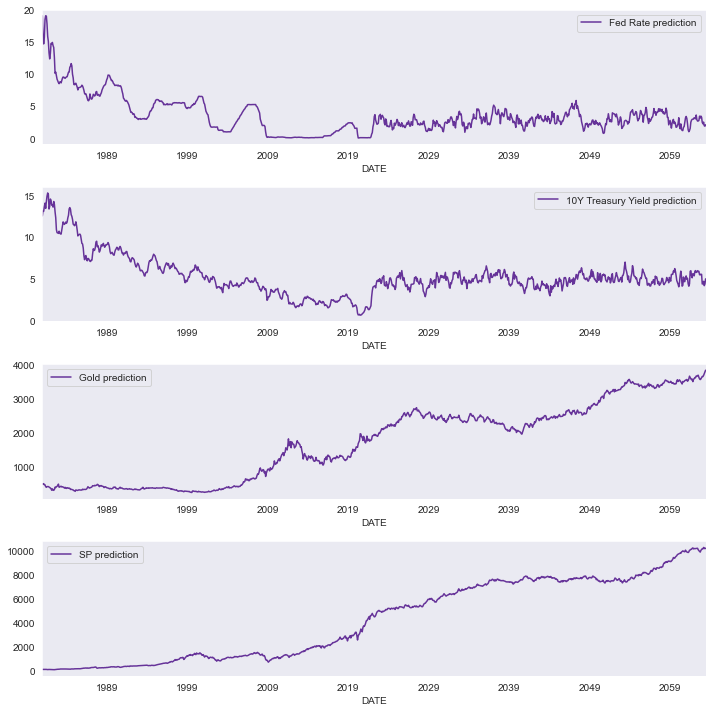

In [247]:
# next forecasts
for i in range(1,no_forecast):

    forecast_input = df_results_change.values[-lag_order:]
    fc = model_fitted.forecast(y=forecast_input, steps=forecast_window)
    month = df_results_change.index[-1]
    next_month = month + 1
    df_forecast.loc[next_month] = fc[0]
    df_results_change.loc[next_month] = fc[0]#[fc[0][0], fc[0][1]]
    epsilon = np.random.multivariate_normal(np.zeros(cov_mat.shape[0]), cov_mat).T
    # mean reversion
    W = np.random.multivariate_normal(np.zeros(2), covariance_matrix).T
    X = np.array([df_results.loc[month,:]['Fed Rate'], df_results.loc[month,:]['10Y Treasury Yield']])
    dX = kappa * (theta - X) + sigma * np.sqrt(abs(X)) * W
    mean_reversion = np.hstack([dX, np.zeros(cov_mat.shape[0] - 2)])
    df_results.loc[next_month] = df_results.loc[month,:] + fc[0] + (epsilon ) * error + mean_reversion

# plot
fig, axes = plt.subplots(nrows=len(df_results.columns),figsize=(10,10))
for i, (col,ax) in enumerate(zip(df_results.columns, axes.flatten())):
    df_results[col].plot(legend=True, ax=ax, color=purple, label=col+ ' prediction').autoscale(axis='x',tight=True)

plt.tight_layout()

In [242]:
mean_reversion = np.hstack([dX, np.zeros(cov_mat.shape[0] - 2)])
mean_reversion

array([0.94578393, 1.20052973, 0.        , 0.        ])

In [234]:
mean_reversion

array([[0.94578393, 1.20052973],
       [0.        , 0.        ]])

In [226]:
np.zeros(2)

array([0., 0.])

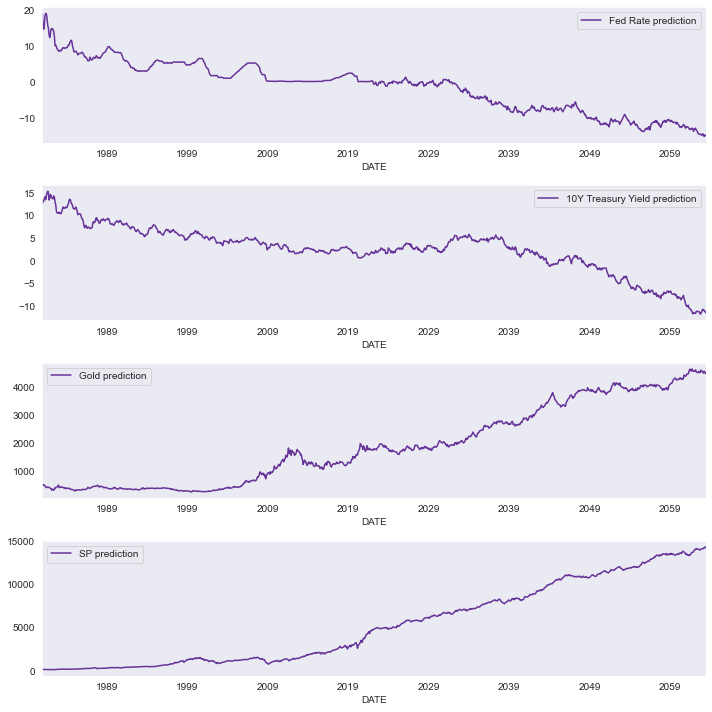

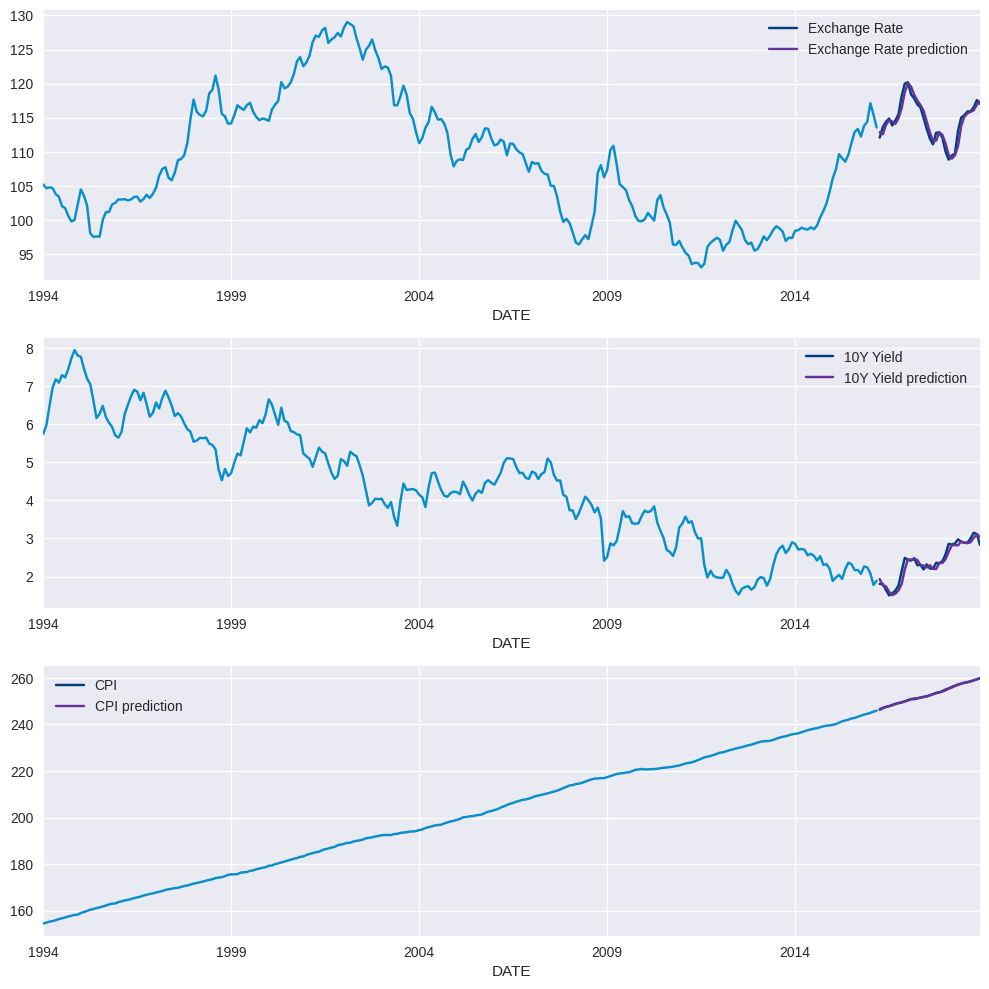

In [ ]:
fig, axes = plt.subplots(nrows=3,figsize=(10,10))
for i, (col,ax) in enumerate(zip(train_df_stationary.columns, axes.flatten())):
    val_df[col].plot(legend=True, ax=ax, color=color_dark_blue);
    train_df[col].plot(legend=False, ax=ax, color=color_light_blue);
    df_results[col].plot(legend=True, ax=ax, color=purple, label=col+ ' prediction').autoscale(axis='x',tight=True);

plt.tight_layout();

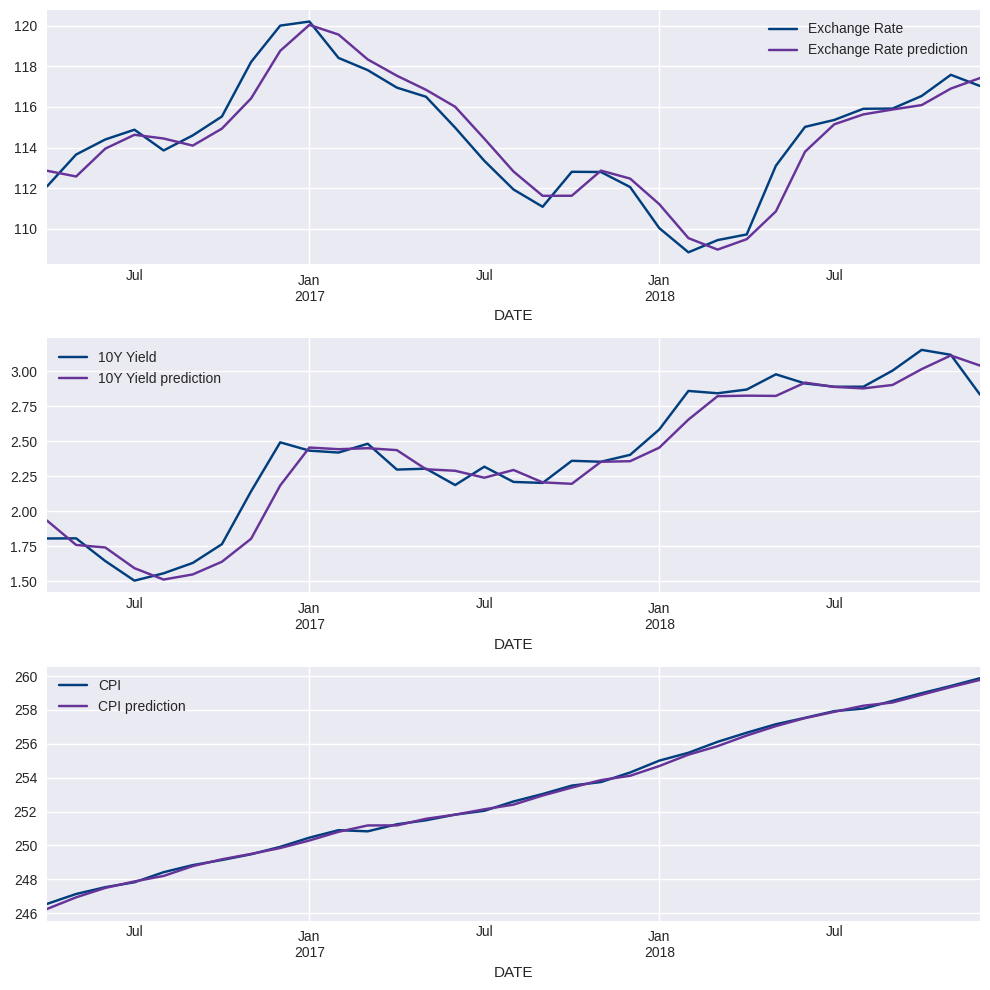

In [ ]:
fig, axes = plt.subplots(nrows=3,figsize=(10,10))
for i, (col,ax) in enumerate(zip(train_df_stationary.columns, axes.flatten())):
    val_df[col].plot(legend=True, ax=ax, color=color_dark_blue);
    #train_df[col].plot(legend=False, ax=ax, color=color_light_blue);
    df_results[col].plot(legend=True, ax=ax, color=purple, label=col+ ' prediction').autoscale(axis='x',tight=True);

plt.tight_layout();

## Test